# Itinéraire pour un trail _off_ sur le GR34

NB: aucune idée de comment gérer l'orga de tout ça (dépose des sacs, nuitées, retour au point de départ, _etc._)

In [1]:
!pip install -r requirements.txt

In [2]:
import gpxpy
from geopy import distance
import numpy as np

gpx_file = open('data/GR34_Sentier_des_douaniers.gpx', 'r')

gpx = gpxpy.parse(gpx_file)
all_points = [[p.latitude, p.longitude] for p in gpx.tracks[0].segments[0].points]

# Subset of interest
idx0 = 245
indices = [idx0, 750, 1220, 1625]
places = ["Cancale", "Dinard", "Saint-Cast", "Sables d'Or"]
points = all_points[indices[0]:indices[-1]+1]

# Shift everything
indices = [idx - idx0 for idx in indices]

# Cumulative distances
point2point_distances = [0] + [distance.distance(points[i], points[i - 1]).m for i in range(1, len(points))]
cumulative_distances = np.cumsum(point2point_distances)

In [3]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Polyline, Marker
from ipywidgets import HTML

south = max([p[0] for p in points]) + 1
north = min([p[0] for p in points]) - 1
west = min([p[1] for p in points]) - 1
east = max([p[1] for p in points]) + 1
center = [(south + north) / 2, (west + east) /2]

m = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=center, zoom=11)

# Draw line
line = Polyline(locations=points, color="green", fill=False)
m.add_layer(line)

# Add markers
for idx, title in zip(indices, places):
    marker = Marker(location=points[idx], draggable=False)
    marker.popup = HTML(title + f" ({cumulative_distances[idx] / 1000:.1f}km)")
    m.add_layer(marker)



In [4]:
m

Map(center=[48.64139, -2.1189999999999998], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

In [5]:
import requests

def get_elevations(points):
    max_segment_length = 100
    i = 0
    elevations = []
    while i * max_segment_length < len(points):
        idx_start, idx_end = i * max_segment_length, (i + 1) * max_segment_length
        latitudes = [f"{p[0]:.5f}" for p in points[idx_start:idx_end]]
        longitudes = [f"{p[1]:.5f}" for p in points[idx_start:idx_end]]

        url_api_ign = f"https://wxs.ign.fr/calcul/alti/rest/elevationLine.json?lon={'|'.join(longitudes)}&lat={'|'.join(latitudes)}"

        res = requests.get(url_api_ign)
        res = res.json()["elevations"]
        cur_elevations = [r["z"] for r in res]
        elevations.extend(cur_elevations)
        i += 1
    return elevations

elevations = get_elevations(points)
delta_elev = [elevations[i] - elevations[i-1] for i in range(1, len(elevations))]

print(f"D+: {sum([d for d in delta_elev if d > 0]):.1f}m")
print(f"D-: {sum([-d for d in delta_elev if d < 0]):.1f}m")


D+: 2676.1m
D-: 2686.0m


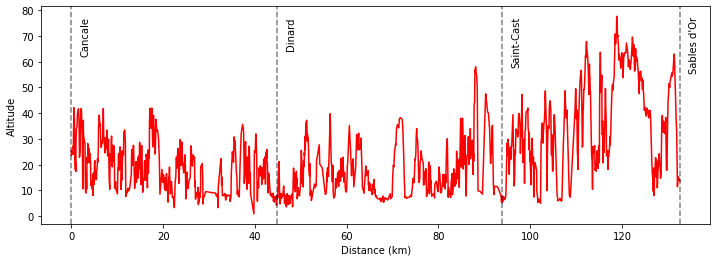

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(cumulative_distances / 1000, elevations, 'r-')
for idx, title in zip(indices, places):
    plt.axvline(x=cumulative_distances[idx] / 1000, color='k', linestyle='--', alpha=.5)
    plt.text(x=cumulative_distances[idx] / 1000 + 2, y=np.max(elevations), s=title, rotation=90, verticalalignment='top')
plt.ylabel("Altitude")
plt.xlabel("Distance (km)");


In [7]:
# Cumulative distances for all points
point2point_distances = [0] + [distance.distance(all_points[i], all_points[i - 1]).m for i in range(1, len(all_points))]
cumulative_distances = np.cumsum(point2point_distances)

idx_900 = min([idx for idx in range(len(all_points)) if cumulative_distances[idx] >= 850 * 1000])
idx_1200 = min([idx for idx in range(len(all_points)) if cumulative_distances[idx] >= 1100 * 1000])

# Subset of interest
idx0 = idx_900
indices = [idx0, idx_1200]
places = ["km900", "km1200"]
points = all_points[indices[0]:indices[-1]+1]

# Shift everything
indices = [idx - idx0 for idx in indices]

# Cumulative distances
point2point_distances = [0] + [distance.distance(points[i], points[i - 1]).m for i in range(1, len(points))]
cumulative_distances = np.cumsum(point2point_distances)

south = max([p[0] for p in points]) + 1
north = min([p[0] for p in points]) - 1
west = min([p[1] for p in points]) - 1
east = max([p[1] for p in points]) + 1
center = [(south + north) / 2, (west + east) /2]

m2 = Map(basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik), center=center, zoom=9)

# Draw line
line = Polyline(locations=points, color="green", fill=False)
m2.add_layer(line)

# Add markers
for idx, title in zip(indices, places):
    marker = Marker(location=points[idx], draggable=False)
    marker.popup = HTML(title + f" ({cumulative_distances[idx] / 1000:.1f}km)")
    m2.add_layer(marker)
    
elevations = get_elevations(points)
delta_elev = [elevations[i] - elevations[i-1] for i in range(1, len(elevations))]

print(f"D+: {sum([d for d in delta_elev if d > 0]):.1f}m")
print(f"D-: {sum([-d for d in delta_elev if d < 0]):.1f}m")

D+: 5651.4m
D-: 5655.1m


In [8]:
m2

Map(center=[48.19891, -4.458275], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

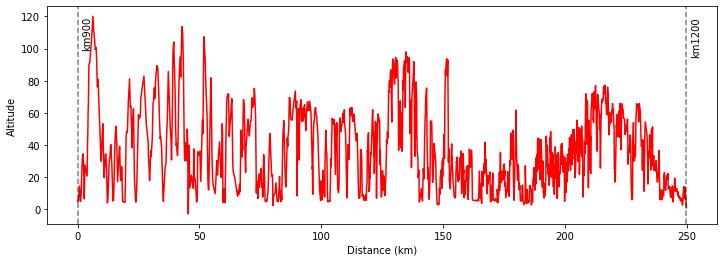

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(cumulative_distances / 1000, elevations, 'r-')
for idx, title in zip(indices, places):
    plt.axvline(x=cumulative_distances[idx] / 1000, color='k', linestyle='--', alpha=.5)
    plt.text(x=cumulative_distances[idx] / 1000 + 2, y=np.max(elevations), s=title, rotation=90, verticalalignment='top')
plt.ylabel("Altitude")
plt.xlabel("Distance (km)");